# Evidential Deep Regression

In [ ]:
import joblib
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


# import evidential library
import evidential_deep_learning as edl

from matplotlib import pyplot as plt  
import uncertainty_toolbox as uct

# goat3 import methods 
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

#imported to hide tensorflow & plot warnings
import warnings
warnings.filterwarnings('ignore')

## Load & Preprocess data

In [ ]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])
X_encoded = preprocessor.fit_transform(X)

In [ ]:
TEST_SIZE = 0.1 # size of test data 0.1 = 10% of the data

#split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=TEST_SIZE)
print(f"X_train : {len(X_train)}  |  X_test : {len(X_test)} ")
print(f"y_train : {len(y_train)}  |  y_test : {len(y_test)} ")

## Model 

In [ ]:
BS = 32 # Batch Size
EPOCHS = 100 # Number of Epochs
COEFF = 1e-2 # Regularization term
LR = 1e-4 # Learning Rate

In [48]:

# Define the model with an evidential output 
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation="relu"),
    edl.layers.DenseNormalGamma(1),
])

# define the evidential loss function 
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=COEFF)

# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss=EvidentialRegressionLoss,
    metrics=['mae'])

# Train model
print("[INFO] training ...")
history = model.fit(X_train, y_train,batch_size = BS, epochs=
                    EPOCHS, validation_split=0.1,verbose = 0)
print("[INFO] done!")

[INFO] training ...
[INFO] done!


In [49]:
y_train_pred = model.predict(X_train)

206/206 [==============================] - 0s 1ms/step


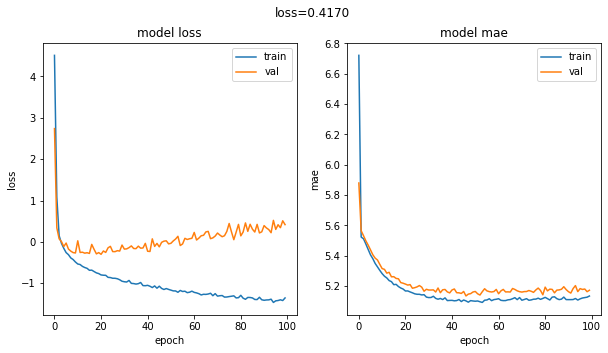

In [50]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.suptitle("loss={:5.4f}".format(history.history["val_loss"][-1]))

plt.show()

In [51]:
output_train = model(X_train)

In [52]:
if np.array_equal(y_train_pred, output_train):
    print("Equal")
else:
    print("Not Equal")

Equal


In [53]:
# Get model outputs 
output_test = model(X_test)
output_train = model(X_train)

# Split the output to get the 4 parameters mu, alpha, v, beta for the TEST SET
mu, v, alpha, beta = tf.split(output_test, 4, axis=-1)
mu = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))
print(var.shape)
var = np.minimum(var, 1e3)[:, 0]

# Split the output to get the 4 parameters mu, alpha, v, beta for the TRAIN SET
mu_tr, v_tr, alpha_tr, beta_tr = tf.split(output_train, 4, axis=-1)
mu_tr = mu_tr[:, 0]
var_tr = np.sqrt(beta_tr / (v_tr * (alpha_tr - 1)))
var_tr = np.minimum(var_tr, 1e3)[:, 0]



# Compute the two uncertainties 
alea = np.array(beta / (alpha - 1)) # aleatoric uncertainty  
epist = beta / (v*(alpha - 1)) # epistemic uncertainty

(732, 1)


In [54]:
y_test.shape

(732,)

In [55]:
aleatoric = np.reshape(alea,y_test.shape)
epistemic = np.reshape(epist,y_test.shape)

Text(0.5, 1.0, 'comparing the two types of uncertainties')

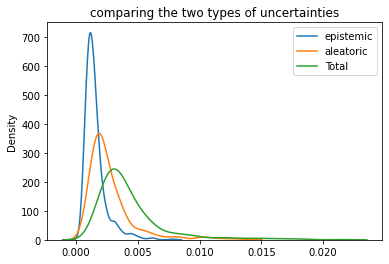

In [63]:
# Plot the two types of uncertainties
#sns.set_theme(style="whitegrid")
sns.distplot(aleatoric, hist = False, label = 'epistemic')
sns.distplot(epistemic, hist = False)
sns.distplot(epistemic+aleatoric, hist = False)
plt.legend(['epistemic','aleatoric', "Total"])
plt.title("comparing the two types of uncertainties")

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

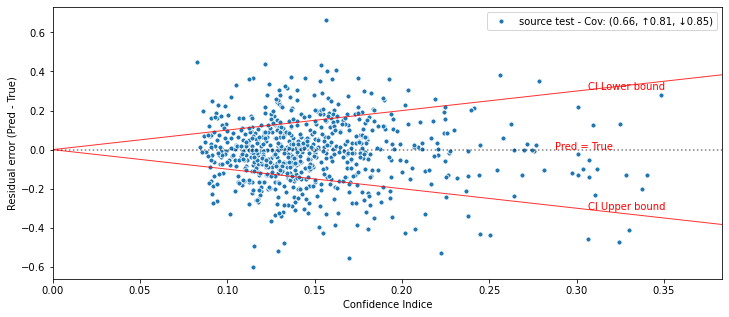

In [57]:
# Compute the evaluation metrics
#metrics = uct.metrics.get_all_metrics(np.array(mu), np.array(epistemic), np.array(y_test))
#uct.viz.plot_calibration(np.array(mu),  np.array(var) , np.array(y_test))
plot_confidence_v2(y_test,np.array(mu) , np.array(mu)-3*np.array(var), np.array(mu)+3*np.array(var), label='source test')

## Calibration

In [66]:
total = aleatoric+epistemic

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.66it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.126
  RMSE          0.166
  MDAE          0.098
  MARPD         1.603
  R2            0.978
  Correlation   0.989
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.022
  Mean-absolute Calibration Error       0.018
  Miscalibration Area                   0.018
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.030
     Group Size: 1.00 -- Calibration Error: 0.018
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.074
     Group Size: 0.56 -- Calibration Error: 0.033
     Group Size: 1.00 -- Calibration Error: 0.022
================

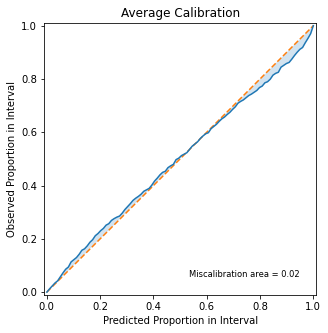

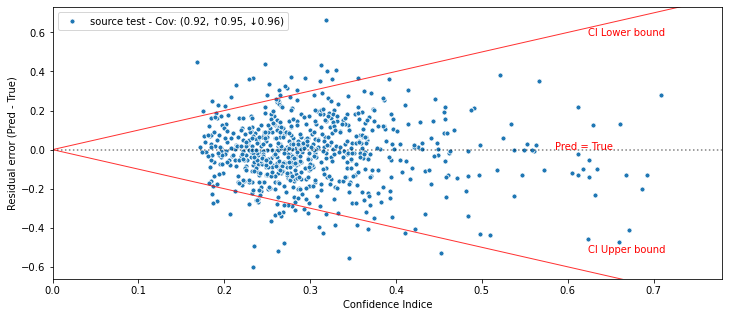

In [70]:
# Get the calibration function (fitted calibrator)
recalibrator = uct.recalibration.get_std_recalibrator(np.array(mu),  np.array(var), np.array(y_test), criterion='ma_cal')

# Get the new standard deviations 
new_stds = recalibrator(var)

# Plot the calibration curve
uct.viz.plot_calibration(np.array(mu),  np.array(new_stds) , np.array(y_test))

# Plot the Coverage curve
plot_confidence_v2(y_test,np.array(mu) , np.array(mu)-2*new_stds, np.array(mu)+2*new_stds, label='source test')

# Compute the metrics
metrics = uct.metrics.get_all_metrics(np.array(mu), np.array(new_stds), np.array(y_test))

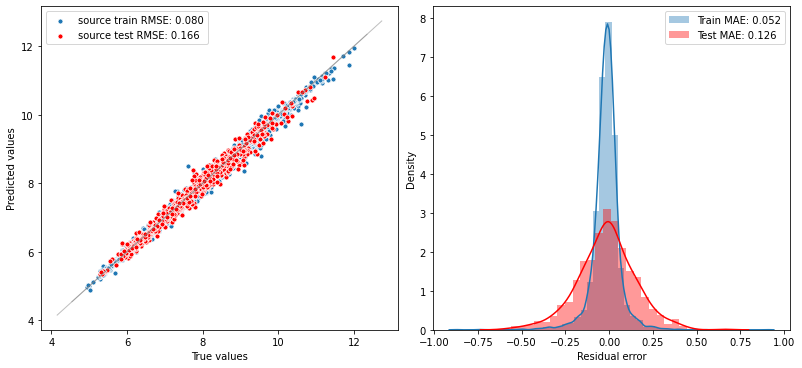

In [65]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]);ax2 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, np.array(mu_tr), label='source train',  ax=ax1, score='RMSE')
plot_adequation(y_test,np.array(mu), label='source test', ax=ax1,score='RMSE', color='red')
ax1.grid(False)
plot_residuals(y_train, np.array(mu_tr), kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, np.array(mu), kind='hist', label='Test', ax=ax2, score='MAE', color ='red')
ax2.grid(False)

### Save Metrics

In [ ]:
import pickle

with open('DER_metrics_dense.pkl', 'wb') as f:
    pickle.dump(metrics, f)